Our main goal is to be able to represent loaded music. We will use FFT for that.
What are the needs?
We're creating a video, let's say, 5 mins long, of 60fps. That means, we have 18.000 video frames in total.
If the incoming audio is of 44.100 sample rate, for each video frame we have 735 samples, so that would be our window for FFT analysis.

But, there's another thing to consider. The resulting texture.
Should it be updated each frame and contain only that window? Time consuming, we could fall off off being real time.
Or maybe we should prepare one texture of the whole song, where on Y axis it'd have FFT for a single frame, and frames would be put on X axis? Tat would be best, BUT - in case of our sampe 5mins long video it'd mean 18K length, that's not an option to load up as a texture into OpenGL...

First, let's see different options for signal analysis.

In [1]:
import numpy as np

sample_rate = 44100
frequency = 440
length = 1

t = np.linspace(0, length, sample_rate * length)
y = np.sin(frequency * 2 * np.pi * t)    
simple_sine_wave_440Hz = y

In [2]:
from scipy import signal

sampleRate = 44100
frequency_start = 1000
frequency_end = 8000
length = 1

t = np.linspace(0, length, sampleRate * length)
y = signal.chirp(t, f0=frequency_start, f1=frequency_end, t1=length)
m = np.max(np.abs(y))
maxint16 = np.iinfo(np.int16).max
y = maxint16 * y / m
y = y.astype(np.int16) 
freq_sweep_sine = y

In [3]:
sampleRate = 44100
ts = 1.0 / sample_rate
frequency_1 = 500
frequency_2 = 3000
frequency_3 = 6000
frequency_4 = 10000
length = 1

t = np.linspace(0, length, sample_rate * length)
y = np.sin(frequency_1 * 2 * np.pi * t)
y += np.sin(frequency_2 * 2 * np.pi * t)
y += np.sin(frequency_3 * 2 * np.pi * t)
y += np.sin(frequency_4 * 2 * np.pi * t)

multi_sine_4freqs = y

In [4]:
def get_audio_part(audio, time_start=0.0, sample_rate=44100, frame_rate=30, nframes = 1):
    samples_per_frame = int(sample_rate / frame_rate)
    sample_start = int(time_start * sample_rate)
    sample_end = sample_start + (nframes * samples_per_frame)
    N = sample_end - sample_start
    T = 1.0 / sample_rate
    t = np.linspace(0, nframes * (1.0 / frame_rate), int(sample_rate * nframes * (1.0 / frame_rate)))
    audio_part = audio[sample_start:sample_end]
    return (audio_part, N, T, t)

Simple FFT analysis

c:\Users\pito\.conda\envs\Python312PySide6\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\pito\.conda\envs\Python312PySide6\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


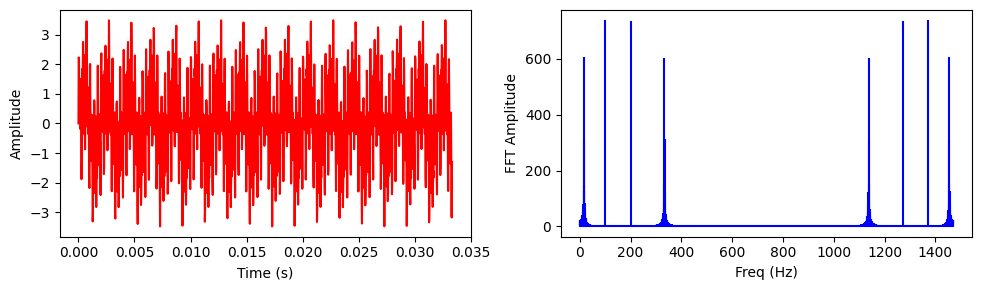

In [5]:
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

signal, N, T, t = get_audio_part(multi_sine_4freqs, time_start=0.0, sample_rate=44100, frame_rate=30, nframes=1)

signal_fft = fft(signal)
freq = t/T

plt.figure(figsize = (10, 3))

plt.subplot(121)
plt.plot(t, ifft(signal_fft), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(122)
plt.stem(freq, np.abs(signal_fft), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude')

plt.tight_layout()
plt.show()

Let's get rid of the mirrored imaginary part of FFT.

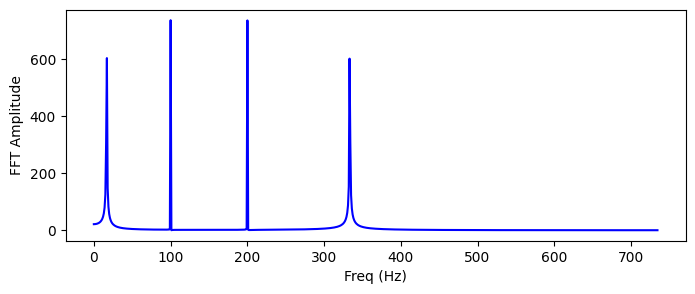

In [6]:
signal, N, T, t = get_audio_part(multi_sine_4freqs, time_start=0.0, sample_rate=44100, frame_rate=30, nframes=1)

signal_fft = fft(signal)
freq = t/T

N_half = int(N/2)
freqs_oneside = freq[0:N_half]

plt.figure(figsize = (8, 3))
plt.plot(freqs_oneside, np.abs(signal_fft[:N_half]), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude')
plt.show()

Let's try to filter the amplitudes a bit.
We will use a Hann window for this task.

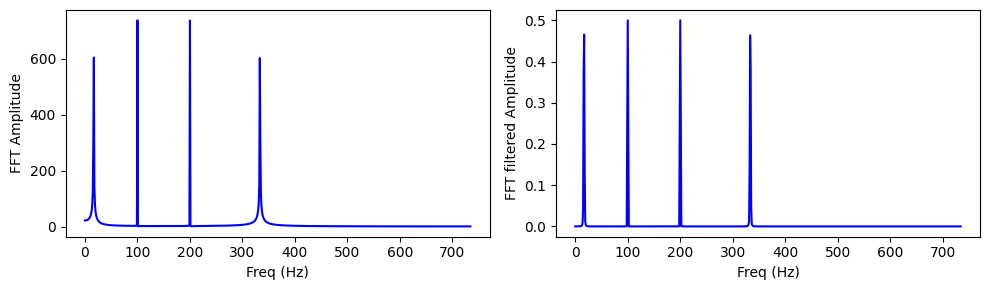

In [7]:
from scipy.signal.windows import hann
from scipy.fft import fftfreq

signal, N, T, t = get_audio_part(multi_sine_4freqs, time_start=0.0, sample_rate=44100, frame_rate=30, nframes=1)
signal_fft = fft(signal)
freq = t/T
N_half = int(N/2)
freqs_oneside = freq[:N_half]

w = hann(N) # Hann window
c_w = abs(sum(w))
signal_fft_filtered = fft(signal * w) / c_w

plt.figure(figsize = (10, 3))
plt.subplot(121)
plt.plot(freqs_oneside, np.abs(signal_fft[:N_half]), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude')
plt.subplot(122)
plt.plot(freqs_oneside, np.abs(signal_fft_filtered[:N_half]), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT filtered Amplitude')
plt.tight_layout()
plt.show()

The last option looks like the best option for visualizing the amplitudes of frequencies.

Nest step is the implementation. The big thing is ShaderToy has its own, very specific, and maybe not the best way of implementing this. That means as a first step we will do it in compliance with ShaderTy, but once we implement another feature in the app, which is individual settings for each loaded texture, we could also add other implementations.

So, what exactly **ShaderToy** is saying about this texture?

It's a **512x2** bitmap. First row is frequencies amplitudes. It is containing 48kHz/4 (**12kHz**) in those 512 texels - on a **linear** Hz scale.
The second row of a texture is a sound wave.

In [17]:
from PIL import Image

def array_to_red_image(array) -> Image:
    """Makes an image from NDArray. Array values are transferred into R channel of RGB."""
    img = None
    # get absolute values
    array = abs(array)
    # get max value
    max = np.max(array)
    # normalize to 0.0 - 1.0 range
    arrayuint8 = array.astype(np.float64) / max
    # make it uint8 data
    arrayuint8 = 255 * arrayuint8
    # grey image from array
    img = Image.fromarray(arrayuint8.astype(np.uint8), mode='L')
    # empty grey image
    zero = np.zeros(array.shape, dtype=np.uint8)
    img_zero = Image.fromarray(zero, mode='L')
    # merge it. Real image goes to R channel, while G and B channels filled with zeroes
    img = Image.merge(mode='RGB', bands=(img, img_zero, img_zero))
    return img

Size of signal FFT: 1470


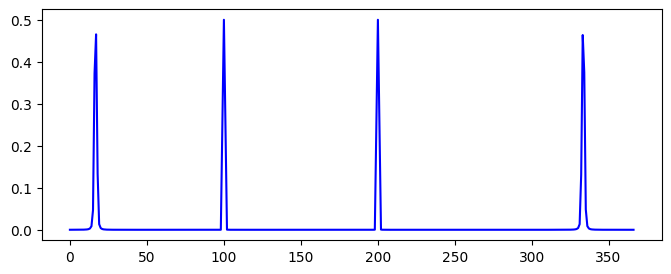

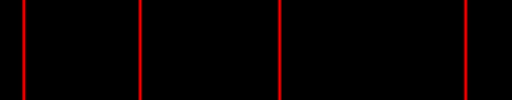

In [18]:
signal, N, T, t = get_audio_part(multi_sine_4freqs, time_start=0.0, sample_rate=44100, frame_rate=30, nframes=1)

w = hann(N) # Hann window
c_w = abs(sum(w))
signal_fft = fft(signal * w) / c_w
print(f'Size of signal FFT: {signal_fft.size}')

N_part = int(N/4)
freq = t/T
freqs_part = freq[:N_part]
signal_fft_part = signal_fft[:N_part]

plt.figure(figsize = (8, 3))
plt.plot(freqs_part, np.abs(signal_fft_part), 'b')
plt.show()

fft_img = array_to_red_image(signal_fft_part)
fft_img = fft_img.rotate(90, expand=True)
fft_img = fft_img.resize((512,100))
display(fft_img)


Let's collect both parts into one texture.

In [28]:
def merge_images(img1: Image, img2: Image):
    img = None
    final_width = np.max([img1.size[0], img2.size[0]])
    final_height = img1.size[1] + img2.size[1]
    img = Image.new('RGB', size=(final_width, final_height))
    img.paste(img1, (0, 0))
    img.paste(img2, (0, img1.size[1]))
    return img

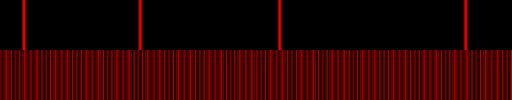

In [29]:
signal, N, T, t = get_audio_part(multi_sine_4freqs, time_start=0.0, sample_rate=44100, frame_rate=30, nframes=1)

wave_img = array_to_red_image(signal)
wave_img = wave_img.rotate(90, expand=True)
wave_img = wave_img.resize((512,50))

w = hann(N) # Hann window
c_w = abs(sum(w))
signal_fft = fft(signal * w) / c_w
N_part = int(N/4)
signal_fft_part = signal_fft[:N_part]
fft_img = array_to_red_image(signal_fft_part)
fft_img = fft_img.rotate(90, expand=True)
fft_img = fft_img.resize((512,50))

final_img_100px = merge_images(fft_img, wave_img)
display(final_img_100px)

wave_img_1px = array_to_red_image(signal)
wave_img_1px = wave_img_1px.rotate(90, expand=True)
wave_img_1px = wave_img_1px.resize((512,1))
fft_img_1px = array_to_red_image(signal_fft_part)
fft_img_1px = fft_img_1px.rotate(90, expand=True)
fft_img_1px = fft_img_1px.resize((512,1))

final_img_1px = merge_images(fft_img_1px, wave_img_1px)
display(final_img_1px)


Test on some real music:

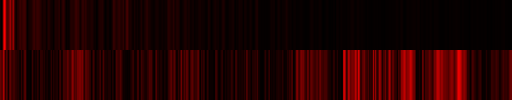

In [60]:
import librosa
audio, sample_rate = librosa.load('test_sound_01.mp3', mono=True, sr=44100)
signal, N, T, t = get_audio_part(audio, time_start=45.0, sample_rate=sample_rate, frame_rate=30, nframes=1)
wave_img = array_to_red_image(signal)
wave_img = wave_img.rotate(90, expand=True)
wave_img_100px = wave_img.resize((512,50))
wave_img_1px = wave_img.resize((512,1))
w = hann(N) # Hann window
c_w = abs(sum(w))
signal_fft = fft(signal * w) / c_w
N_part = int(N/4)
signal_fft_part = signal_fft[:N_part]
fft_img = array_to_red_image(signal_fft_part)
fft_img = fft_img.rotate(90, expand=True)
fft_img_100px = fft_img.resize((512,50))
fft_img_1px = fft_img.resize((512,1))
final_img_100px = merge_images(fft_img_100px, wave_img_100px)
final_img_1px = merge_images(fft_img_1px, wave_img_1px)
display(final_img_100px)

One more thing... let's test the conversion process to QImage.

In [61]:
from PySide6.QtGui import QImage
img = final_img_1px
final_width, final_height = img.size
texture = QImage(img.tobytes(), final_width, final_height, final_width*3, QImage.Format_RGB888)
texture.save('final_texture.png')

True